In [1]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 31.7 MB/s eta 0:00:00


In [2]:
import SimpleITK as sitk
from types import SimpleNamespace
import yaml
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import numpy.random as random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import flow_to_image
from PIL import Image

In [3]:
class RayDataset(Dataset):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.batch_size = args.batch_size

        fixed = sitk.ReadImage(args.fixed_vol_path) # fixed_vol_path is the path to the fixed volume
        self.props = [
            fixed.GetSize(),
            fixed.GetOrigin(),
            fixed.GetSpacing(),
            fixed.GetDirection(),
        ]
        fixed = sitk.GetArrayFromImage(fixed) # fixed is the fixed volume
        fixed_mask = sitk.ReadImage(
            args.fixed_vol_path.replace(".mha", "_mask.mha")
        )
        fixed_mask = sitk.GetArrayFromImage(fixed_mask) # fixed_mask is the mask of the fixed volume
        self.fixed = torch.from_numpy(
            fixed_mask * (fixed - args.min_val) / args.std_val
        ) # fixed is the fixed volume after normalization

        self.H, self.D, self.W = self.fixed.shape # H is the height, D is the depth, W is the width
        self.vol_size = self.H * self.D * self.W # vol_size is the total number of voxels in the fixed volume
        self.vol_shape = torch.tensor(([self.W, self.D, self.H])) # vol_shape is the shape of the fixed volume

        index_h = torch.linspace(-1.0, 1.0, self.H + 1)[:-1] + 1 / self.H # index_h is the height index
        index_d = torch.linspace(-1.0, 1.0, self.D + 1)[:-1] + 1 / self.D # index_d is the depth index
        index_w = torch.linspace(-1.0, 1.0, self.W + 1)[:-1] + 1 / self.W # index_w is the width index
        grid_h, grid_d, grid_w = torch.meshgrid(
            [index_h, index_d, index_w], indexing="ij"
        ) # grid_h, grid_d, grid_w are the height, depth, and width grids
        pts = torch.stack([grid_w, grid_d, grid_h], -1) # pts is the grid of the fixed volume
        self.pts = pts

        self.indexs = np.repeat(np.arange(self.vol_size), args.num_repeat)

        self.pts_vec = self.pts.view(-1, 3)
        self.vals_vec = self.fixed.view(-1, 1)

    def __len__(self):
        return self.vol_size // self.batch_size

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        indexs = self.indexs[start: end]
        pts = self.pts_vec[indexs]
        vals = self.vals_vec[indexs]

        return dict(pts=pts, vals=vals)

    def shuffle(self):
        random.shuffle(self.indexs)

    def random_plane(self, view="axial"):
        if view == "axial":
            index = random.choice(range(self.H))
            pts = self.pts[index, :, :]
            vals = self.fixed[index, :, :]
        elif view == "sagital":
            index = random.choice(range(self.D))
            # index = 278
            pts = self.pts[:, index, :]
            vals = self.fixed[:, index, :]
        elif view == "coronal":
            index = random.choice(range(self.W))
            pts = self.pts[:, :, index]
            vals = self.fixed[:, :, index]
        return pts, vals, index

    def all_planes(self):
        return self.pts, self.fixed

    def tensor2vol(self, tensor, dvf=False):
        if dvf:
            tensor = tensor * self.vol_shape.to(tensor.device)
        else:
            tensor = tensor * self.args.std_val + self.args.min_val
        array = tensor.cpu().numpy()
        vol = sitk.GetImageFromArray(array)
        if dvf:
            vol = sitk.Cast(vol, sitk.sitkVectorFloat32)
        else:
            vol = sitk.Cast(vol, sitk.sitkInt16)
        vol.SetOrigin(self.props[1])
        vol.SetSpacing(self.props[2])
        vol.SetDirection(self.props[3])
        return vol


In [4]:
class Embedder(nn.Module):
    def __init__(self, input_ch, inc_input, max_freq, N_freqs):
        super().__init__()
        self.freq_bands = 2.0 ** torch.linspace(0.0, max_freq, steps=N_freqs)
        self.out_dim = 2 * N_freqs * input_ch
        if inc_input:
            self.out_dim += input_ch

    def forward(self, x):
        x = x * np.pi
        sin = [torch.sin(x * freq_band) for freq_band in self.freq_bands]
        cos = [torch.cos(x * freq_band) for freq_band in self.freq_bands]
        oup = torch.cat(sin + cos, -1)
        return oup


class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(
                    -1 / self.in_features, 1 / self.in_features
                )
            else:
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_features) / self.omega_0,
                    np.sqrt(6 / self.in_features) / self.omega_0,
                )

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class NeRF(nn.Module):
    def __init__(self, args, D=8, W=256, input_ch=4, output_ch=4, skips=[4], multi_res=8):
        super(NeRF, self).__init__()
        self.skips = skips
        self.embedder = Embedder(input_ch, False, multi_res - 1, multi_res)
        input_ch = self.embedder.out_dim

        self.pts_linears = nn.ModuleList(
            [SineLayer(input_ch, W)]
            + [
                SineLayer(W, W)
                if i not in self.skips
                else SineLayer(W + input_ch, W)
                for i in range(D - 1)
            ]
        )

        self.output_linear = nn.Linear(W, output_ch, bias=False)
        with torch.no_grad():
            nn.init.zeros_(self.output_linear.weight)

        moving = sitk.ReadImage(args.moving_vol_path)
        moving = sitk.GetArrayFromImage(moving)
        moving_mask = sitk.ReadImage(
            args.moving_vol_path.replace(".mha", "_mask.mha")
        )
        moving_mask = sitk.GetArrayFromImage(moving_mask)
        moving = torch.from_numpy(
            moving_mask * (moving - args.min_val) / args.std_val
        ).float()
        self.register_buffer('moving', moving)


    def forward(self, x):
        # print(x.shape)
        x = self.embedder(x)
        identity = x
        for i, linear in enumerate(self.pts_linears):
            x = linear(x)
            if i in self.skips:
                x = torch.cat([identity, x], -1)

        outputs = self.output_linear(x)

        return outputs

    def sample_moving(self, pts):
        for i in range(5 - len(pts.shape)):
            pts = pts.unsqueeze(0)
        vals = F.grid_sample(self.moving[None, None], pts, align_corners=False)
        return vals

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
with open("/content/drive/MyDrive/Colab Notebooks/ETHZ/main/config.yaml") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
args = SimpleNamespace(**config)

cuda


In [6]:
args

namespace(fixed_vol_path='/content/drive/MyDrive/Colab Notebooks/ETHZ/data/case02/case2_T00-ssm.mha',
          min_val=0,
          std_val=4247,
          num_repeat=1,
          moving_vol_path='/content/drive/MyDrive/Colab Notebooks/ETHZ/data/case02/case2_T50-ssm.mha',
          netdepth=8,
          netwidth=256,
          multires=10,
          bounding_box=[[0, 0, 0], [256, 256, 112]],
          num_epochs=24,
          batch_size=2048,
          lr=0.00012,
          lambda_jacob=0.05,
          lambda_hyper=0.25,
          num_step_opt=1,
          num_step_log=10,
          num_step_val=400,
          num_val_planes=4,
          chunk_size=32768,
          num_epoch_save=1,
          ckpt_nvf_path='/content/drive/MyDrive/Colab Notebooks/ETHZ/check/case02/case02.pth')

In [7]:
dataset = RayDataset(args)
dataloader = DataLoader(
    dataset, batch_size=None, shuffle=True, pin_memory=True
)
dataset.props

[(256, 256, 112),
 (0.0, 0.0, 0.0),
 (1.16, 1.16, 2.5),
 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)]

In [8]:
movs_i, prds_i = [], []
pts, vals, index = dataset.random_plane()
print(index)
H, W, D = pts.shape
print(pts.shape)
pts = pts.reshape(-1, 3).to(device)
vals = vals.reshape(-1, 1).to(device)

for j in range(0, H * W, args.chunk_size):
    pts_j = pts[j : j + args.chunk_size]
    vals_j = vals[j : j + args.chunk_size]
    print(pts_j.shape)
    print(vals_j.shape)
    break

111
torch.Size([256, 256, 3])
torch.Size([32768, 3])
torch.Size([32768, 1])


In [9]:
model = NeRF(args, args.netdepth, args.netwidth, multi_res=args.multires).to(device)
model.load_state_dict(torch.load(args.ckpt_nvf_path)["model"])

<All keys matched successfully>

In [10]:
movs_i, prds_i = [], []
pts, vals, index = dataset.random_plane()
print(index)
H, W, D = pts.shape
print(pts.shape)
pts = pts.reshape(-1, 3).to(device)
vals = vals.reshape(-1, 1).to(device)

for j in range(0, H * W, args.chunk_size):
    pts_j = pts[j : j + args.chunk_size]
    vals_j = vals[j : j + args.chunk_size]
    print(pts_j)

    with torch.no_grad():
        time0 = torch.zeros((len(pts_j), 1)).to(device)

        off_time1 = model(torch.concatenate((pts_j, time0), dim=1))
        tmp1 = pts_j + 1 / 2 * off_time1[:, :3]
        time1 = 1 / 2 * torch.ones((len(pts_j), 1)).to(device)

        off_time2 = model(torch.concatenate((tmp1, time1), dim=1))
        tmp2 = tmp1 + 1 / 2 * off_time2[:, :3]

    new_pts_j = tmp2
    offs_j = new_pts_j - pts_j

    movs_j = model.sample_moving(pts_j).view(-1, 1)
    prds_j = model.sample_moving(new_pts_j).view(-1, 1)

    movs_i.append(movs_j)
    prds_i.append(prds_j)

movs_i = torch.cat(movs_i)
prds_i = torch.cat(prds_i)

movs = movs_i.view(H, W)
prds = prds_i.view(H, W)
gts = vals.view(H, W)

103
torch.Size([256, 256, 3])
tensor([[-0.9961, -0.9961,  0.8482],
        [-0.9883, -0.9961,  0.8482],
        [-0.9805, -0.9961,  0.8482],
        ...,
        [ 0.9805, -0.0039,  0.8482],
        [ 0.9883, -0.0039,  0.8482],
        [ 0.9961, -0.0039,  0.8482]], device='cuda:0')
tensor([[-0.9961,  0.0039,  0.8482],
        [-0.9883,  0.0039,  0.8482],
        [-0.9805,  0.0039,  0.8482],
        ...,
        [ 0.9805,  0.9961,  0.8482],
        [ 0.9883,  0.9961,  0.8482],
        [ 0.9961,  0.9961,  0.8482]], device='cuda:0')


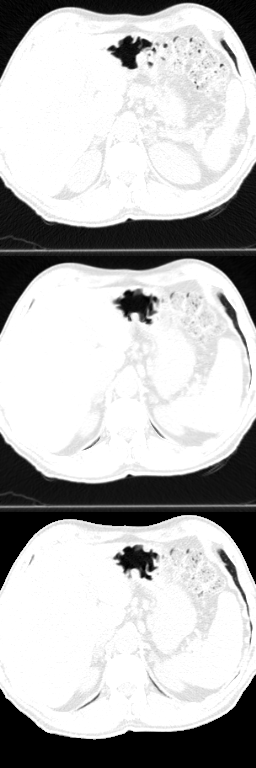

In [11]:
visuals = torch.cat((movs, prds, gts), 0).detach().cpu().numpy()
im = Image.fromarray(1024 * visuals)
im.show(visuals)

In [128]:
fixed = sitk.ReadImage(args.fixed_vol_path)
fixed = sitk.GetArrayFromImage(fixed) # fixed is the fixed volume
fixed_mask = sitk.ReadImage(
    args.fixed_vol_path.replace(".mha", "_mask.mha")
)
fixed_mask = sitk.GetArrayFromImage(fixed_mask) # fixed_mask is the mask of the fixed volume
fixed = torch.from_numpy(
    fixed_mask * (fixed - args.min_val) / args.std_val
) # fixed is the fixed volume after normalization
H, D, W = fixed.shape
H, D, W

(112, 256, 256)

In [153]:
index_h = torch.linspace(-1.0, 1.0, H + 1)[:-1] + 1 / H # index_h is the height index

tensor([0.0000, 0.0179, 0.0357, 0.0536, 0.0714, 0.0893, 0.1071, 0.1250, 0.1429,
        0.1607, 0.1786, 0.1964, 0.2143, 0.2321, 0.2500, 0.2679, 0.2857, 0.3036,
        0.3214, 0.3393, 0.3571, 0.3750, 0.3929, 0.4107, 0.4286, 0.4464, 0.4643,
        0.4821, 0.5000, 0.5179, 0.5357, 0.5536, 0.5714, 0.5893, 0.6071, 0.6250,
        0.6429, 0.6607, 0.6786, 0.6964, 0.7143, 0.7321, 0.7500, 0.7679, 0.7857,
        0.8036, 0.8214, 0.8393, 0.8571, 0.8750, 0.8929, 0.9107, 0.9286, 0.9464,
        0.9643, 0.9821, 1.0000, 1.0179, 1.0357, 1.0536, 1.0714, 1.0893, 1.1071,
        1.1250, 1.1429, 1.1607, 1.1786, 1.1964, 1.2143, 1.2321, 1.2500, 1.2679,
        1.2857, 1.3036, 1.3214, 1.3393, 1.3571, 1.3750, 1.3929, 1.4107, 1.4286,
        1.4464, 1.4643, 1.4821, 1.5000, 1.5179, 1.5357, 1.5536, 1.5714, 1.5893,
        1.6071, 1.6250, 1.6429, 1.6607, 1.6786, 1.6964, 1.7143, 1.7321, 1.7500,
        1.7679, 1.7857, 1.8036, 1.8214, 1.8393, 1.8571, 1.8750, 1.8929, 1.9107,
        1.9286, 1.9464, 1.9643, 1.9821])

In [101]:
data00 = "/content/drive/MyDrive/Colab Notebooks/ETHZ/data/case02/Case2_300_T00_xyz.txt"
data50 = "/content/drive/MyDrive/Colab Notebooks/ETHZ/data/case02/Case2_300_T50_xyz.txt"

In [209]:
image_size = [256, 256, 112]
scale_of_axes = [(0.5 * s) for s in image_size]
scale_of_axes

[128.0, 128.0, 56.0]

In [227]:
pts = np.loadtxt(data50)
vals = np.loadtxt(data00)
vol = np.array([1.16, 1.16, 2.5])

mean = np.mean((pts - vals) * vol, 0)
mean, np.linalg.norm(mean, 2)

(array([ 0.18333333, -0.33333333, -1.51333333]), 1.5604166110369373)

In [233]:
pts_j = torch.tensor(pts / scale_of_axes, dtype=torch.float32).to(device)
vals_j = torch.tensor(vals / scale_of_axes, dtype=torch.float32).to(device)
vals[1], vals_j[1]

(array([233., 111.,  52.]), tensor([1.8203, 0.8672, 0.9286], device='cuda:0'))

In [234]:
with torch.no_grad():
    time0 = torch.zeros((len(pts_j), 1)).to(device)

    off_time1 = model(torch.concatenate((pts_j, time0), dim=1))
    tmp1 = pts_j + 1 / 2 * off_time1[:, :3]
    time1 = 1 / 2 * torch.ones((len(pts_j), 1)).to(device)

    off_time2 = model(torch.concatenate((tmp1, time1), dim=1))
    tmp2 = tmp1 + 1 / 2 * off_time2[:, :3]

new_pts_j = tmp2

In [235]:
mean_error = torch.mean((new_pts_j - vals_j) * torch.tensor(scale_of_axes).to(device) * torch.tensor(vol).to(device), dim=0)
mean_error, torch.norm(mean_error)

(tensor([ 0.6505, -0.0313, -3.6615], device='cuda:0', dtype=torch.float64),
 tensor(3.7190, device='cuda:0', dtype=torch.float64))